In [67]:
import ee
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

import geemap
from geeml.utils import eeprint

In [68]:
pts = ee.FeatureCollection('projects/ee-geethensingh/assets/aliens_sep2018')
eeprint(pts.limit(5))

In [69]:
def createComposite(imageCollection: str, point: ee.Geometry, year: int):
    """Creates a composite image of a point over a given year.
    
    Args:
        imageCollection (str): The collection to use for the composite.
        point (ee.Geometry): The point to create the composite for.
        year (int): The year to create the composite for.
    
    Returns:
        ee.Image: The composite image.
    """

    # Get the image collection
    ic = ee.ImageCollection(imageCollection)

    if year == 2018:
        startDate = '2018-09-01'
        endDate = '2018-10-01'
    elif year == 2023:
        startDate = '2023-10-01'
        endDate = '2023-12-01'

    # Mask clouds using cloud score+
    csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')

    QA_BAND = 'cs_cdf'
    CLEAR_THRESHOLD = 0.65
    
    # Filter the collection to the start and end dates, and point
    medianImage = ic.filterDate(startDate, endDate).filterBounds(point).linkCollection(csPlus, [QA_BAND])\
    .map(lambda img: img.updateMask(img.select(QA_BAND).gte(CLEAR_THRESHOLD)))\
    .median()
    
    return medianImage.divide(10000)

def getSpectralSignature(image: ee.Image, point: ee.Geometry, scale: int = 10):
    """Plots the spectral signature of a point on an image.
    
    Args:
        image (ee.Image): The image to plot the spectral signature on.
        point (ee.Geometry): The point to plot the spectral signature for.
        includeMap (bool, optional): Whether to include a map of the image. Defaults to True.
        scale (int, optional): The scale to plot the spectral signature at. Defaults to None.
    """

    # Get the spectral signature of the point
    spectralSignature = image.select('B.*').reduceRegion(reducer = ee.Reducer.first()
                                                        , geometry = point
                                                        , scale = scale)

    # Convert to geodataframe
    pts_gdf = ee.data.computeFeatures({
        'expression': spectralSignature,
        'fileFormat': 'PANDAS_DATAFRAME'
    })
    
    return pts_gdf

def plot_spectral_and_map(ds, crs_from='EPSG:32610', crs_to='EPSG:4326'):
    """
    Plot both spectral signature and location map for a random point, including a bounding box.
    
    Parameters:
    ds: xarray Dataset containing spectral data
    crs_from: The CRS of your input coordinates (default UTM Zone 10N)
    crs_to: The target CRS (default WGS84)
    """
    

In [70]:
point = pts.first().geometry()

composite2018 = createComposite("COPERNICUS/S2_HARMONIZED", point, 2018)
eeprint(composite2018)

Map = geemap.Map()
Map.addLayer(composite2018, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, '2018 composite')
Map.addLayer(point, {'color': 'red'}, 'random point')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

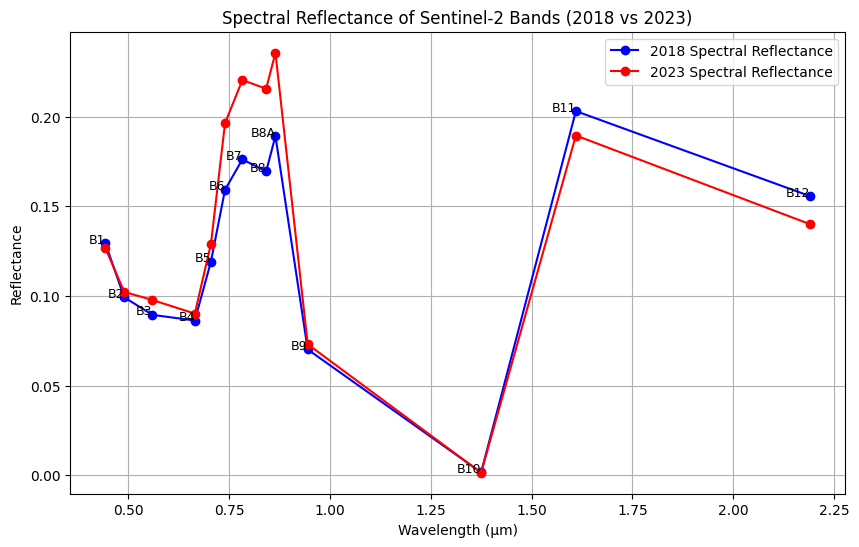

In [71]:
# Function to plot spectral signatures and display the map
def plot_spectral_signatures_and_map(point, composite2018, composite2023):
    # Get the spectral signature of the point for 2018 and 2023
    refl2018 = composite2018.select('B.*').reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=point,
        scale=10
    ).getInfo()

    refl2023 = composite2023.select('B.*').reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=point,
        scale=10
    ).getInfo()

    # Central wavelengths for Sentinel-2 bands (in micrometers)
    wl = {
        "B1": 0.443,  # Coastal aerosol
        "B2": 0.490,  # Blue
        "B3": 0.560,  # Green
        "B4": 0.665,  # Red
        "B5": 0.705,  # Vegetation red edge
        "B6": 0.740,  # Vegetation red edge
        "B7": 0.783,  # Vegetation red edge
        "B8": 0.842,  # NIR
        "B8A": 0.865, # Narrow NIR
        "B9": 0.945,  # Water vapor
        "B10": 1.375, # SWIR - Cirrus
        "B11": 1.610, # SWIR
        "B12": 2.190  # SWIR
    }

    # Extract reflectance values for each band and sort by wavelength
    def get_sorted_data(refl):
        reflectance = {band: refl[band] for band in wl.keys()}
        sorted_data = sorted(zip(wl.values(), reflectance.values(), wl.keys()), key=lambda x: x[0])
        wavelengths, reflectance_values, bands = zip(*sorted_data)
        return wavelengths, reflectance_values, bands

    wavelengths2018, reflectance2018, bands2018 = get_sorted_data(refl2018)
    wavelengths2023, reflectance2023, bands2023 = get_sorted_data(refl2023)

    # Create the spectral plot
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths2018, reflectance2018, marker='o', linestyle='-', color='b', label='2018 Spectral Reflectance')
    plt.plot(wavelengths2023, reflectance2023, marker='o', linestyle='-', color='r', label='2023 Spectral Reflectance')

    # Add labels and title
    plt.xlabel('Wavelength (µm)')
    plt.ylabel('Reflectance')
    plt.title('Spectral Reflectance of Sentinel-2 Bands (2018 vs 2023)')
    plt.grid(True)

    # Annotate the bands
    for band, x, y in zip(bands2018, wavelengths2018, reflectance2018):
        plt.text(x, y, band, fontsize=9, ha='right')

    # Show the plot
    plt.legend()
    plt.show()

    # Display the map with the composite and the point
    Map = geemap.Map()
    Map.addLayer(composite2018, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, '2018 composite')
    Map.addLayer(composite2023, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, '2023 composite')
    Map.addLayer(point, {'color': 'red'}, 'random point')
    Map.centerObject(point, zoom=12)
    Map

# Example usage
point = pts.first().geometry()  # Replace `pts` with your feature collection
composite2018 = createComposite("COPERNICUS/S2_HARMONIZED", point, 2018)
composite2023 = createComposite("COPERNICUS/S2_HARMONIZED", point, 2023)

# Plot spectral signatures and display the map
plot_spectral_signatures_and_map(point, composite2018, composite2023)

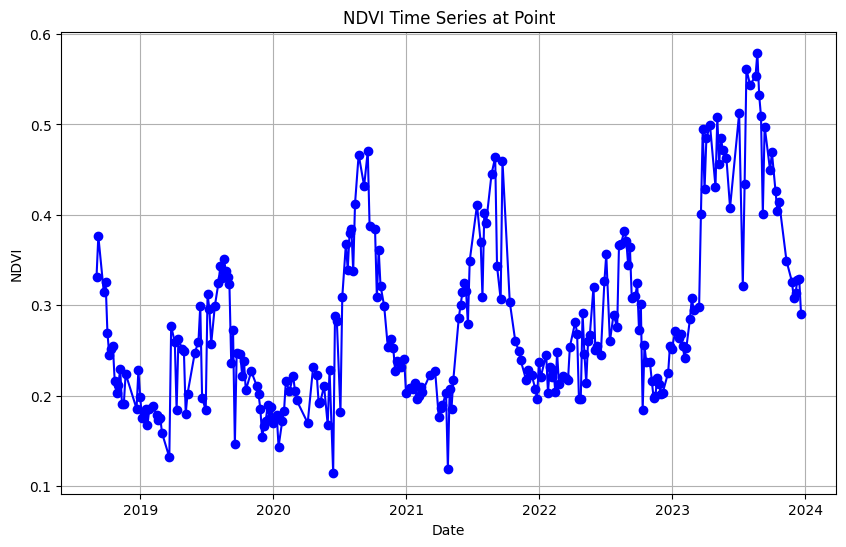

In [72]:
# plot spectral index over time 
import ee
import pandas as pd

# Initialize Earth Engine
ee.Initialize()

# Function to compute a spectral index
def compute_index(image, index_name):
    """
    Compute a spectral index for an image.
    Supported indices: NDVI, EVI, NDWI, etc.
    """
    if index_name == 'NDVI':
        # NDVI = (NIR - Red) / (NIR + Red)
        index = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    elif index_name == 'EVI':
        # EVI = 2.5 * (NIR - Red) / (NIR + 6 * Red - 7.5 * Blue + 1)
        evi = image.expression(
            '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
            {
                'NIR': image.select('B8'),
                'RED': image.select('B4'),
                'BLUE': image.select('B2')
            }
        ).rename('EVI')
        index = evi
    elif index_name == 'NDWI':
        # NDWI = (Green - NIR) / (Green + NIR)
        index = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    else:
        raise ValueError(f"Unsupported index: {index_name}")
    return image.addBands(index)

# Function to extract a spectral index over time for a point
def extract_index_over_time(point, index_name, start_date, end_date, scale=10):
    """
    Extract a spectral index over time for a specific point.
    
    Args:
        point (ee.Geometry): The point to extract the index for.
        index_name (str): The spectral index to compute (e.g., 'NDVI', 'EVI', 'NDWI').
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.
        scale (int): Scale in meters for the reduceRegion operation.
    
    Returns:
        pd.DataFrame: A DataFrame with dates and index values.
    """

    # Mask clouds using cloud score+
    csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')

    QA_BAND = 'cs_cdf'
    CLEAR_THRESHOLD = 0.65

    # Load the Sentinel-2 image collection
    collection = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterBounds(point) \
        .filterDate(start_date, end_date)\
        .linkCollection(csPlus, [QA_BAND])\
        .map(lambda img: compute_index(img.updateMask(img.select(QA_BAND).gte(CLEAR_THRESHOLD)), index_name))

    # Extract the index values over time
    def extract_index(image):
        # Reduce the region to the point
        value = image.reduceRegion(
            reducer=ee.Reducer.first(),
            geometry=point,
            scale=scale
        )
        # # Return the date and index value
        return image.set('date', image.date().format('YYYY-MM-dd')).set(value)

    # Map over the collection to extract values
    time_series = collection.map(extract_index).filter(ee.Filter.notNull([index_name]))

    # Convert the time series to a list of dictionaries
    time_series_list = time_series.aggregate_array(index_name).getInfo()
    date_list = time_series.aggregate_array('date').getInfo()

    # Convert to a pandas DataFrame
    df = pd.DataFrame(date_list, columns=['date'])
    df['date'] = pd.to_datetime(df['date'])
    df[index_name] = time_series_list
    df = df.sort_values('date').reset_index(drop=True)

    return df

# Example usage
point = pts.first().geometry()
index_name = 'NDVI'  # Choose the index (e.g., 'NDVI', 'EVI', 'NDWI')
start_date = '2018-09-01'
end_date = '2023-12-31'

# Extract the index over time
time_series_df = extract_index_over_time(point, index_name, start_date, end_date)

# Plot the time series
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(time_series_df['date'], time_series_df[index_name], marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel(index_name)
plt.title(f'{index_name} Time Series at Point')
plt.grid(True)
plt.show()

In [73]:
timelapse = geemap.sentinel2_timelapse(
    point.buffer(5000),
    out_gif='sentinel2.gif',
    start_year= 2018,
    end_year= 2020,
    start_date='09-01',
    end_date='12-01',
    frequency='week',
    bands=['SWIR2','NIR', 'Red'],
    frames_per_second=1,
    title='Sentinel-2 Timelapse',
)
geemap.show_image(timelapse)

Generating URL...
Please wait ...
The GIF image has been saved to: /home/geethen/invasives/hypinvalimap/code/sentinel2.gif
No module named 'ffmpeg'


Output()

dynamic world probabilities over time  
sentinel-2 spectral signatures for the same periods over multiple years
create gif  
plot hyperspectral signature for two periods  
Classify pt as same/changed/toClass/inconclusive  

In [ ]:
# extract values at points
data = dem.reduceRegions(collection=pts, reducer=ee.Reducer.first(), scale=30)
data.limit(5)

# convert to geopandas dataframe
pts_gdf = ee.data.computeFeatures({
    'expression': data,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

# Need to set the CRS.
# Make sure it matches the CRS of FeatureCollection geometries.
pts_gdf.crs = 'EPSG:4326'

display(type(pts_gdf))
pts_gdf.head()